# Membrane under a gaussian-distributed load
Here we use pyiron as the workflow manager, and FEniCS as a finite-element solver to solve Poisson equation for the defelection of the membrane.   
1. First, we define the problem for a single load on a circular membrane with a radius of 1.  
2. Second, we change the width the load, here defined as `beta`, and finally plot the load for each case. 

In [1]:
from pyiron import Project
import pyiron_contrib
import numpy as np
import matplotlib.pyplot as plt

### 1. Defining a pyiron project
At first, we define one single job which simulate one single gaussian load and calculate the defelection

In [2]:
pr = Project('membrane')
pr.remove_jobs_silently(recursive=True)

In [3]:
job = pr.create.job.Fenics('mem_default')

In [4]:
job.input

InputList({'mesh_resolution': 2, 'element_type': 'P', 'element_order': 1})

### 2. Defining a circular domain

In [5]:
job.domain = job.create.domain.circle((0, 0), 1)

In [6]:
help(job.create.domain.circle)

Help on method circle in module pyiron_contrib.continuum.fenics:

circle(center, radius) method of pyiron_contrib.continuum.fenics.DomainFactory instance



### 3. Generating the mesh

In [7]:
job.input.mesh_resolution = 64
job.input.element_type = 'P'
job.input.element_order = 2

**Visualizing the mesh**

In [8]:
job.mesh

### 4. Defining the boundary condition 
Here it is assumed that the boundary of the membrane is fixed and therefore the deflection is zero at the boundary

In [9]:
w_D = job.Constant(0)

def boundary(x, on_boundary):
    return on_boundary

In [10]:
job.BC = job.DirichletBC(w_D, boundary)

### 5. Defining the gaussian load
The gaussian expression is defined with parameter `beta` and `R0`, where `beta` specifies the width of the gaussian expression. One can change this width using `p.beta =<new value>`

In [11]:
beta = 8
R0 = 0.6
p = job.Expression('4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))',
               degree=1, beta=beta, R0=R0)

### 6. Defining the variational formulation of Poisson equation
Here `u` represents the deflection and `v` is the test function.

In [12]:
job.LHS = job.dot(job.grad(job.u), job.grad(job.v)) * job.dx
job.RHS = p * job.v * job.dx

### 7. Running the job

In [13]:
job.run()

The job mem_default was saved and received the ID: 153


In [14]:
type(job.u)

dolfin.function.function.Function

### 8. Visualizing the deflection

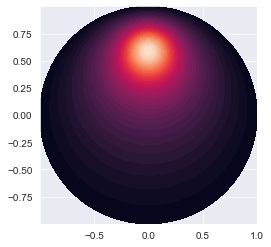

In [15]:
job.plot_u()

## Defining multiple jobs
Here we define multiple job for various `beta`, and solve Poisson equation for each loading.

In [16]:
betas=[5,6,8,10]
tol = 0.001
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]
w_line = [] 
p_line = []
for beta in betas:
    p.beta = beta;
    job_name="mem_{}".format(beta) 
    pr.remove_job(job_name)
    
    job_beta = pr.create.job.Fenics("mem_{}".format(beta))
    job_beta.input.mesh_resolution = 64
    job_beta.input.element_type = 'P'
    job_beta.input.element_order = 2
    job_beta.domain = job.create.domain.circle((0, 0), 1)
    job_beta.BC = job_beta.DirichletBC(w_D, boundary)
    
    job_beta.LHS = job_beta.dot(job_beta.grad(job_beta.u), job_beta.grad(job_beta.v)) * job_beta.dx
    p.beta = beta
    job_beta.RHS = p * job_beta.v * job_beta.dx
    
    job_beta.run()

    w_line.append(np.array([job_beta.u(point) for point in points]))
    p_line.append(np.array([p(point) for point in points]))

2020-12-10 22:42:41,902 - pyiron_log - WARNING - Job 'mem_5' does not exist and cannot be loaded
2020-12-10 22:42:41,903 - pyiron_log - WARNING - Job 'mem_5' does not exist and could not be removed


The job mem_5 was saved and received the ID: 154


2020-12-10 22:42:43,160 - pyiron_log - WARNING - Job 'mem_6' does not exist and cannot be loaded
2020-12-10 22:42:43,162 - pyiron_log - WARNING - Job 'mem_6' does not exist and could not be removed


The job mem_6 was saved and received the ID: 155


2020-12-10 22:42:44,500 - pyiron_log - WARNING - Job 'mem_8' does not exist and cannot be loaded
2020-12-10 22:42:44,501 - pyiron_log - WARNING - Job 'mem_8' does not exist and could not be removed


The job mem_8 was saved and received the ID: 156


2020-12-10 22:42:45,919 - pyiron_log - WARNING - Job 'mem_10' does not exist and cannot be loaded
2020-12-10 22:42:45,920 - pyiron_log - WARNING - Job 'mem_10' does not exist and could not be removed


The job mem_10 was saved and received the ID: 157


### Visualization of the loads and defelections

Text(0.5, 1.0, 'Deflection/Load along y axis')

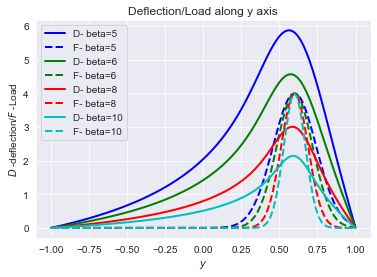

In [17]:
colors=['b', 'g','r', 'c','k']
%matplotlib inline
for color, beta, deflection, pline in zip(colors,betas,w_line, p_line):
    plt.plot(y, 50*deflection, color, linewidth=2, label = 'D- beta={}'.format(beta))  # magnify w
    plt.plot(y, pline,  color+'--', linewidth=2, label = 'F- beta={}'.format(beta))

plt.grid(True)
plt.xlabel('$y$')
plt.ylabel('$D$ -deflection/$F$ -Load')
plt.legend( loc='upper left')
plt.title("Deflection/Load along y axis")